<a href="https://colab.research.google.com/github/AndrewstheBuilder/VideoSemanticSearch_JiuJitsu/blob/main/CNN_JiuJitsu_Film.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training

### Process trainset

In [22]:
!unzip /content/trainset.zip -d /content/trainset

Archive:  /content/trainset.zip
replace /content/trainset/guarded/frame_10980.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [23]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [24]:
transform = transforms.Compose(
    [ transforms.Resize((64, 64)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data_path = './trainset/'
train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)

In [25]:
batch_size = 4 # You can adjust the batch size based on memory availability
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
classes = train_dataset.classes

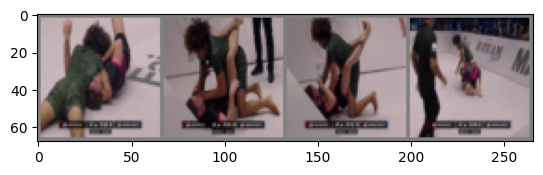

pinning guarded guarded standing


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
classes = train_dataset.classes

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define CNN architecture and Train

In [68]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [69]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epochs=7

In [70]:
net.train()
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # for name, param in net.named_parameters():
        #   if param.requires_grad:
        #       print(f'{name} grad: {param.grad.abs().mean()}')
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % batch_size == batch_size-1:    # print every batch_size mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / batch_size:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     4] loss: 1.401
[1,     8] loss: 1.354
[1,    12] loss: 1.325
[1,    16] loss: 1.363
[1,    20] loss: 1.097
[1,    24] loss: 1.203
[1,    28] loss: 1.122
[1,    32] loss: 1.411
[1,    36] loss: 0.962
[1,    40] loss: 0.863
[1,    44] loss: 0.859
[1,    48] loss: 1.056
[1,    52] loss: 0.765
[1,    56] loss: 1.008
[1,    60] loss: 0.968
[1,    64] loss: 0.805
[1,    68] loss: 0.929
[1,    72] loss: 1.128
[1,    76] loss: 0.939
[1,    80] loss: 0.868
[1,    84] loss: 0.639
[1,    88] loss: 0.697
[1,    92] loss: 0.928
[1,    96] loss: 0.815
[2,     4] loss: 0.633
[2,     8] loss: 0.668
[2,    12] loss: 0.658
[2,    16] loss: 0.801
[2,    20] loss: 0.900
[2,    24] loss: 1.337
[2,    28] loss: 0.856
[2,    32] loss: 0.859
[2,    36] loss: 0.591
[2,    40] loss: 0.670
[2,    44] loss: 0.729
[2,    48] loss: 0.667
[2,    52] loss: 0.520
[2,    56] loss: 0.646
[2,    60] loss: 0.731
[2,    64] loss: 0.495
[2,    68] loss: 0.624
[2,    72] loss: 0.848
[2,    76] loss: 0.686
[2,    80] 

In [71]:
print('labels',labels)
classes = train_dataset.classes
print('classes',classes)
t = torch.tensor([[[1, 2],[3, 4]],[[5, 6],[7, 8]]])
print('t.shape',t.shape)
t_flat = torch.flatten(t, 1)
print('t_flat.shape',t_flat.shape)

labels tensor([3])
classes ['guarded', 'none', 'pinning', 'standing']
t.shape torch.Size([2, 2, 2])
t_flat.shape torch.Size([2, 4])


In [72]:
PATH = './kaggle_net.pth'
torch.save(net.state_dict(), PATH)

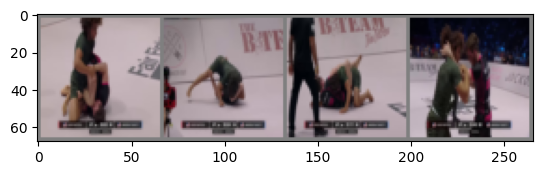

GroundTruth:  guarded pinning guarded standing


In [73]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [74]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [75]:
outputs = net(images)

In [76]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  guarded pinning guarded standing


In [77]:
correct = 0
total = 0
# Set the model to evaluation mode
net.eval()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 training images: {100 * correct // total} %')

Accuracy of the network on the 10000 training images: 95 %


In [78]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Set the model to evaluation mode
net.eval()

# again no gradients needed
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: guarded is 96.1 %
Accuracy for class: none  is 97.4 %
Accuracy for class: pinning is 89.9 %
Accuracy for class: standing is 99.2 %


## Validate model on test set

### Process Test Set

In [39]:
!unzip /content/testset.zip -d /content/testset

Archive:  /content/testset.zip
  inflating: /content/testset/guarded/frame_1890.jpg  
  inflating: /content/testset/guarded/frame_3240.jpg  
  inflating: /content/testset/guarded/frame_4680.jpg  
  inflating: /content/testset/guarded/frame_4860.jpg  
  inflating: /content/testset/guarded/frame_4950.jpg  
  inflating: /content/testset/guarded/frame_5310.jpg  
  inflating: /content/testset/guarded/frame_5490.jpg  
  inflating: /content/testset/guarded/frame_6480.jpg  
  inflating: /content/testset/guarded/frame_6840.jpg  
  inflating: /content/testset/guarded/frame_6930.jpg  
  inflating: /content/testset/guarded/frame_7200.jpg  
  inflating: /content/testset/guarded/frame_7290.jpg  
  inflating: /content/testset/guarded/frame_8190.jpg  
  inflating: /content/testset/none/frame_0000.jpg  
  inflating: /content/testset/none/frame_0540.jpg  
  inflating: /content/testset/none/frame_0630.jpg  
  inflating: /content/testset/none/frame_0720.jpg  
  inflating: /content/testset/none/frame_10080

In [42]:
test_data_path = './testset/'
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Evaluate on test set

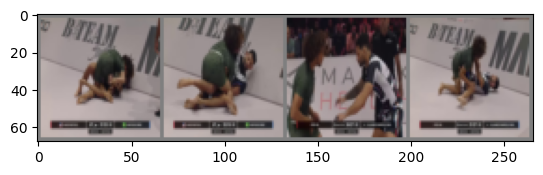

GroundTruth:  pinning pinning standing guarded


In [79]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [80]:
outputs = net(images)

In [81]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  guarded pinning pinning guarded


In [82]:

correct = 0
total = 0
# Set the model to evaluation mode
net.eval()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 training images: {100 * correct // total} %')

Accuracy of the network on the 10000 training images: 65 %


In [83]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Set the model to evaluation mode
net.eval()

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: guarded is 53.8 %
Accuracy for class: none  is 66.0 %
Accuracy for class: pinning is 65.6 %
Accuracy for class: standing is 70.6 %
